# Setup

In [21]:
from pathlib import Path
import json

output_dir = '_prepared_data/arXiv/'
section = 'abstract'
filepath = f"{output_dir}/{section}/train.jsonl"

In [22]:
with open(filepath, 'r') as json_file:
    json_list = list(json_file)
sep = int(len(json_list)/2)
len(json_list)

203037

In [23]:
data = [json.loads(json_str) for json_str in json_list]

In [24]:
def export_data(data, output_dir, filename, append=False):
    print("Writing prepared data to jsonl file")
    mode = 'a+' if append else 'w'
    print(output_dir)
    if not(Path(output_dir).exists()): 
        os.system(f"mkdir -p {output_dir}")
        # os.mkdir(output_dir, 0755)
    with open(output_dir+filename, mode, encoding='utf-8') as f:
        for line in data:
            json_record = json.dumps(line, ensure_ascii=False)
            f.write(json_record + '\n')
    print('Wrote {} records to {}'.format(len(data), output_dir+filename))

In [26]:
export_data(
    data[:sep], 
    output_dir = f"{output_dir}/{section}/", 
    filename   = f"train1.jsonl"
)
export_data(
    data[sep:], 
    output_dir = f"{output_dir}/{section}/", 
    filename   = f"train2.jsonl"
)

Writing prepared data to jsonl file
_prepared_data/arXiv//abstract/
Wrote 101518 records to _prepared_data/arXiv//abstract/train1.jsonl
Writing prepared data to jsonl file
_prepared_data/arXiv//abstract/
Wrote 101519 records to _prepared_data/arXiv//abstract/train2.jsonl


In [11]:
import json
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
def getPath(section="summary", data_split="train", ent_rel="re"):
    return f"_sci{ent_rel}_models/{section}/{data_split}_{ent_rel}.json"


def getDataset(section, data_split):
    filepath = getPath(section, data_split)
    with open(filepath, 'r') as json_file:
        json_list = list(json_file)
    return [json.loads(json_str) for json_str in json_list]

In [13]:
def print_progress(curr, full, desc='', bar_size=50):    
    bar = int((curr+1)/full*bar_size)
    sys.stdout.write(f"\r{desc}[{'='*bar}{' '*(bar_size-bar)}] {curr+1}/{full}")
    sys.stdout.flush()
    if curr+1==full: print()

In [88]:
ent_types = ['Task', 'Method', 'Material', 'Metric', 'OtherScientificTerm', 'Generic']
rel_types = ['PART-OF', 'USED-FOR', 'FEATURE-OF', 'CONJUNCTION', 'EVALUATE-FOR', 'HYPONYM-OF', 'COMPARE']

# Display entity and graph

## Summary

In [149]:
import spacy
from spacy import displacy
from spacy.tokens import Span
from pathlib import Path

colors = {
    'Task':     "#DE3163", 
    "Method":   "#6495ED", 
    "Metric":   "#FF00FF", 
    "Material": "#40E0D0", 
    "OtherScientificTerm": "#9FE2BF", 
    "Generic":  "#FFBF00",
}
options = {"ents": colors.keys(), "colors": colors, "compact": True,}
nlp = spacy.load("en_core_web_sm")

def display_ent(data, savefile=None):
    all_sentences = [j for i in data["sentences"] for j in i]
    flatten_ner = [j for i in data["predicted_ner"] for j in i]

    doc = nlp(" ".join(all_sentences))
    span_list = [Span(doc, start, end+1, ent_type) for start, end, ent_type in flatten_ner]
    doc.set_ents(span_list)
    ents = list(doc.ents)
    result = displacy.render(doc, style="ent", options=options)
    if not (savefile is None):
        output_path = Path("_output_imgs/"+savefile)
        output_path.open("w", encoding="utf-8").write(result)

In [152]:
from graphviz import Digraph

def display_graph(data, filename='kg'):
    all_sentences = [j for i in data["sentences"] for j in i]
    flatten_ner = [j for i in data["predicted_ner"] for j in i]
    flatten_re  = [j for i in data["predicted_re"] for j in i[1]]
    dot = Digraph('Knowledge Graph', filename=filename)
    dot.attr('node', shape='box', style="filled")
    for ner in flatten_ner:
        ent = " ".join(all_sentences[ner[0]:ner[1]+1])
        dot.node(ent, color=colors[ner[2]])
    for re in flatten_re:
        s = " ".join(all_sentences[re[0][0]:(re[0][1]+1)])
        o = " ".join(all_sentences[re[1][0]:(re[1][1]+1)])
        p = re[2]
        dot.edge(s, o, label=p)
    dot.view()



In [166]:
dataset =  getDataset("abstract", "val")
dataset[0].keys()

dict_keys(['doc_key', 'sentences', 'ner', 'relations', 'predicted_ner', 'predicted_re'])

In [167]:
n = 0
display_ent(dataset[n])
display_graph(dataset[n])

In [32]:
# Get graph legend
dot = Digraph('Graph legend', filename="Graph legend")
dot.attr('node', shape='box', style="filled")
for k, v in colors.items():
    dot.node(k, color=v)
dot.view()


'Graph legend.pdf'

In [ ]:
def display_all(data):
    all_sentences = [j for i in data["sentences"] for j in i]
    flatten_ner = [j for i in data["predicted_ner"] for j in i]
    flatten_re  = [j for i in data["predicted_re"] for j in i[1]]
    display_ent(all_sentences, flatten_ner)
    display_graph(all_sentences, flatten_ner, flatten_re, filename=f"img/{data['doc_key']}")

display_all(data_re[3])

# Statistics of IE from Summary

In [89]:
import pandas as pd

def ent_rel_type(dataset):
    col = ["paper_id", "summary"]
    
    ent_stat_df = pd.DataFrame(columns=col+ent_types)
    rel_stat_df = pd.DataFrame(columns=col+rel_types)
    len_dataset = len(dataset)
    
    for idx, data in enumerate(dataset):
        print_progress(idx, len_dataset, 'Processing ')
        
        paper_id = data["doc_key"]
        all_sentences = [j for i in data["sentences"] for j in i]
        flatten_ner = [j for i in data["predicted_ner"] for j in i]
        flatten_re  = [j for i in data["predicted_re"] for j in i[1]]

        # Count entity
        ent_count = {}
        for ent_type in ent_types: ent_count[ent_type]=0
        for ent in flatten_ner:
            ent_count[ent[2]] += 1
        ent_data = [paper_id, " ".join(all_sentences)] + list(ent_count.values())
        row_ent_df = pd.DataFrame([ent_data], columns=col+ent_types)
        ent_stat_df = pd.concat([ent_stat_df, row_ent_df], axis=0)

        # Count relation
        rel_count = {}
        for rel_type in rel_types: rel_count[rel_type]=0
        for rel in flatten_re:
            rel_count[rel[2]] += 1
        rel_data = [paper_id, " ".join(all_sentences)] + list(rel_count.values())
        row_rel_df = pd.DataFrame([rel_data], columns=col+rel_types)
        rel_stat_df = pd.concat([rel_stat_df, row_rel_df], axis=0)
        
    return ent_stat_df, rel_stat_df


## Summary

In [90]:
dataset =  getDataset("summary", "val")
ent_stat_df_val, rel_stat_df_val = ent_rel_type(dataset)

Processing [==================================================] 3604/3604


In [91]:
ent_stat_df_val.head()

,paper_id,summary,Task,Method,Material,Metric,OtherScientificTerm,Generic
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies FL under local differential...,1,4,0,3,2,1
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies a low communication algorit...,1,6,2,0,6,4
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,The paper proposed a differentially private tr...,1,6,0,0,4,4
0,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This submission works on the neural machine tr...,1,6,4,0,6,3
0,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method to introduce * * ...,1,4,0,0,8,3


In [92]:
rel_stat_df_val.head()

,paper_id,summary,PART-OF,USED-FOR,FEATURE-OF,CONJUNCTION,EVALUATE-FOR,HYPONYM-OF,COMPARE
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies FL under local differential...,0,1,1,1,1,0,0
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies a low communication algorit...,0,10,1,2,1,0,0
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,The paper proposed a differentially private tr...,4,5,0,2,0,0,1
0,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This submission works on the neural machine tr...,1,7,0,5,0,5,0
0,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method to introduce * * ...,1,7,0,0,0,0,0


In [93]:
ent_stat_df_val["total"] = ent_stat_df_val[ent_types].apply(lambda row: sum(row), axis=1)
rel_stat_df_val["total"] = rel_stat_df_val[rel_types].apply(lambda row: sum(row), axis=1)


In [101]:
ent_stat_df_val = ent_stat_df_val.convert_dtypes()
print("Summary (validation)")
ent_stat_df_val.describe().loc[["min", "mean", "max"]].T

Summary (validation)


,min,mean,max
Task,0.0,1.514428,12.0
Method,0.0,4.231132,34.0
Material,0.0,0.736404,12.0
Metric,0.0,0.540233,14.0
OtherScientificTerm,0.0,4.304661,30.0
Generic,0.0,2.385683,17.0
total,1.0,13.712542,65.0


In [102]:
rel_stat_df_val = rel_stat_df_val.convert_dtypes()
print("Summary (validation)")
rel_stat_df_val.describe().loc[["min", "mean", "max"]].T

Summary (validation)


,min,mean,max
PART-OF,0.0,0.29162,7.0
USED-FOR,0.0,3.778579,22.0
FEATURE-OF,0.0,0.475583,9.0
CONJUNCTION,0.0,1.038846,12.0
EVALUATE-FOR,0.0,0.716149,11.0
HYPONYM-OF,0.0,0.672031,11.0
COMPARE,0.0,0.463374,9.0
total,0.0,7.436182,38.0


In [97]:
dataset =  getDataset("summary", "train")
ent_stat_df_train, rel_stat_df_train = ent_rel_type(dataset)
ent_stat_df_train["total"] = ent_stat_df_train[ent_types].apply(lambda row: sum(row), axis=1)
rel_stat_df_train["total"] = rel_stat_df_train[rel_types].apply(lambda row: sum(row), axis=1)

Processing [==================================================] 18934/18934


In [103]:
ent_stat_df_train = ent_stat_df_train.convert_dtypes()
print("Summary (train)")
ent_stat_df_train.describe().loc[["min", "mean", "max"]].T

Summary (train)


,min,mean,max
Task,0.0,1.480828,15.0
Method,0.0,4.290852,34.0
Material,0.0,0.743213,16.0
Metric,0.0,0.547798,15.0
OtherScientificTerm,0.0,4.274216,39.0
Generic,0.0,2.39606,24.0
total,0.0,13.732967,108.0


In [ ]:
rel_stat_df_train = rel_stat_df_train.convert_dtypes()
print("Summary (train)")
rel_stat_df_train.describe().loc[["min", "mean", "max"]].T

Summary (train)


,min,mean,max
PART-OF,0.0,0.296134,12.0
USED-FOR,0.0,3.830833,39.0
FEATURE-OF,0.0,0.475652,9.0
CONJUNCTION,0.0,1.071195,16.0
EVALUATE-FOR,0.0,0.750185,15.0
HYPONYM-OF,0.0,0.708303,15.0
COMPARE,0.0,0.465934,13.0
total,0.0,7.598236,78.0


## Abstract

In [106]:
dataset =  getDataset("abstract", "train")
ent_stat_df_train, rel_stat_df_train = ent_rel_type(dataset)
ent_stat_df_train["total"] = ent_stat_df_train[ent_types].apply(lambda row: sum(row), axis=1)
rel_stat_df_train["total"] = rel_stat_df_train[rel_types].apply(lambda row: sum(row), axis=1)

Processing [==================================================] 8379/8379


In [107]:
ent_stat_df_train = ent_stat_df_train.convert_dtypes()
print("Abstract (train)")
ent_stat_df_train.describe().loc[["min", "mean", "max"]].T

Abstract (train)


,min,mean,max
Task,0.0,3.104666,74.0
Method,0.0,8.008832,248.0
Material,0.0,1.496837,18.0
Metric,0.0,1.246449,26.0
OtherScientificTerm,0.0,7.618451,345.0
Generic,0.0,3.742213,81.0
total,0.0,25.217448,782.0


In [108]:
rel_stat_df_train = rel_stat_df_train.convert_dtypes()
print("Abstract (train)")
rel_stat_df_train.describe().loc[["min", "mean", "max"]].T

Abstract (train)


,min,mean,max
PART-OF,0.0,0.466165,19.0
USED-FOR,0.0,7.170784,200.0
FEATURE-OF,0.0,1.04738,40.0
CONJUNCTION,0.0,1.869794,42.0
EVALUATE-FOR,0.0,1.773362,17.0
HYPONYM-OF,0.0,1.422843,20.0
COMPARE,0.0,0.852011,11.0
total,0.0,14.602339,339.0


In [112]:
dataset =  getDataset("abstract", "val")
ent_stat_df_val, rel_stat_df_val = ent_rel_type(dataset)
ent_stat_df_val["total"] = ent_stat_df_val[ent_types].apply(lambda row: sum(row), axis=1)
rel_stat_df_val["total"] = rel_stat_df_val[rel_types].apply(lambda row: sum(row), axis=1)

Processing [==================================================] 1060/1060


In [113]:
ent_stat_df_val = ent_stat_df_val.convert_dtypes()
print("Abstract (val)")
ent_stat_df_val.describe().loc[["min", "mean", "max"]].T

Abstract (val)


,min,mean,max
Task,0.0,3.021698,19.0
Method,0.0,7.950943,28.0
Material,0.0,1.55283,13.0
Metric,0.0,1.303774,19.0
OtherScientificTerm,0.0,7.632075,27.0
Generic,0.0,3.756604,17.0
total,2.0,25.217925,70.0


In [114]:
rel_stat_df_val = rel_stat_df_val.convert_dtypes()
print("Abstract (val)")
rel_stat_df_val.describe().loc[["min", "mean", "max"]].T

Abstract (val)


,min,mean,max
PART-OF,0.0,0.493396,6.0
USED-FOR,0.0,7.149057,23.0
FEATURE-OF,0.0,1.032075,8.0
CONJUNCTION,0.0,1.865094,13.0
EVALUATE-FOR,0.0,1.803774,12.0
HYPONYM-OF,0.0,1.386792,11.0
COMPARE,0.0,0.880189,7.0
total,0.0,14.610377,43.0


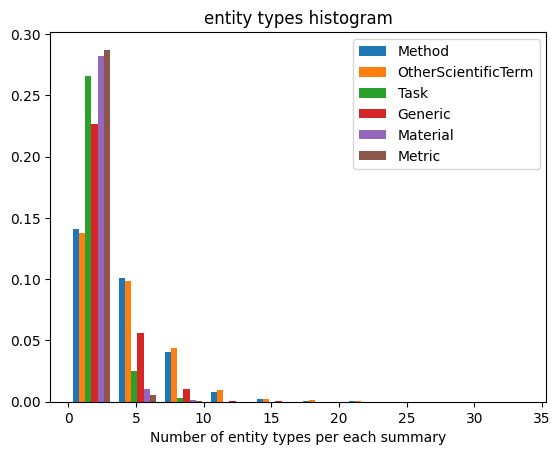

In [66]:
def hist_graph(df, cols, name_count):
    fig, ax = plt.subplots()
    ent_max = max([df[col].max() for col in cols]) 

    ax.hist(df[cols], density=True, histtype='bar', label=cols)
    ax.legend(prop={'size': 10})

    ax.set_xlabel(f"Number of {name_count} per each summary")
    ax.set_title(f"{name_count} histogram")

hist_graph(ent_stat_df, ent_types, name_count="entity types")

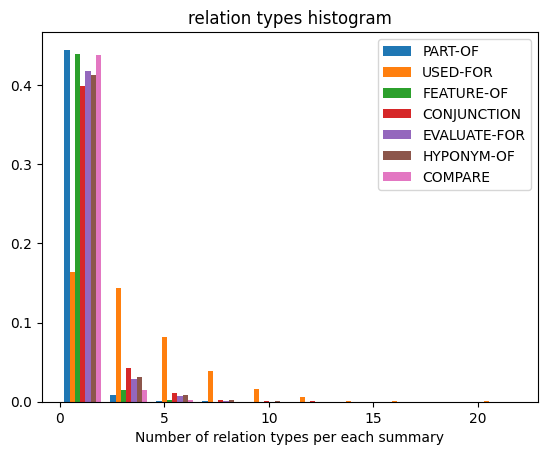

In [ ]:
hist_graph(rel_stat_df, rel_types, name_count="relation types")

# Get sequence of triple

## Class and Functions

In [136]:
import spacy
nlp = spacy.load("en_core_web_sm")


def addTripEnt(allEnt, tripEnt, ent):
    try:
        tripEnt[ent] = allEnt[ent]
    except:
        tripEnt[ent] = None
    return tripEnt



def getTripSeq(data, sym=True):
    sym_rel = ['CONJUNCTION', 'COMPARE']
    all_sentences = [j for i in data["sentences"] for j in i]
    flatten_ner = [j for i in data["predicted_ner"] for j in i]
    flatten_re  = [j for i in data["predicted_re"] for j in i[1]]
    tripSeq = ""
    tripEnt = {}
    allEnt = {}

    for ner in flatten_ner:
        ent = " ".join(all_sentences[ner[0]:ner[1]+1])
        allEnt[ent] = ner[2]

    for rel in flatten_re:
        s = " ".join(all_sentences[rel[0][0]:(rel[0][1]+1)])
        o = " ".join(all_sentences[rel[1][0]:(rel[1][1]+1)])
        p = rel[2]
        tripSeq += f"{s} {p} {o}. "
        if sym and p in sym_rel:
            tripSeq += f"{o} {p} {s}. "
        tripEnt = addTripEnt(allEnt, tripEnt, s)
        tripEnt = addTripEnt(allEnt, tripEnt, o)
        
    freeEnt = allEnt.copy()
    for key, val in tripEnt.items(): freeEnt.pop(key)

    return tripEnt, freeEnt, tripSeq

def getTokenLen(input_text):
    doc_text = nlp(input_text)
    return sum([len(sent) for sent in doc_text.sents])

def calDiff(row):
    return (row['original_len']-row['triple_len'])

def calPercDiff(row):
    return (row['original_len']-row['triple_len'])/row['original_len']*100

def getProcessedLen(dataset):
    col = ["paper_id", "original", "original_len", "free_entities", "trip_entities", "triple_seq", "triple_len"]
    len_df = pd.DataFrame(columns=col)
    len_dataset = len(dataset)
    for i, data in enumerate(dataset):
        tripEnt, freeEnt, tripSeq = getTripSeq(data)
        paper_id = data['doc_key']
        original = [j for i in data["sentences"] for j in i]
        row = pd.DataFrame([[
            paper_id,
            " ".join(original),
            len(original),
            freeEnt,
            tripEnt,
            tripSeq,
            getTokenLen(tripSeq)
        ]],columns=col)
        len_df = pd.concat([len_df, row], axis=0)
        print_progress(i, len_dataset, 'Processing ')
    len_df = len_df.convert_dtypes()
    len_df["diff"] = len_df.apply(lambda row: calDiff(row), axis=1)
    len_df["diff_percent"] = len_df.apply(lambda row: calPercDiff(row), axis=1)
    return len_df

In [5]:
class tripStat:
    def __init__(self, section, data_split):
        self.section = section
        self.data_split = data_split
        self.dataset = getDataset(self.section, self.data_split)
        self.df = getProcessedLen(self.dataset)
        self.df["diff_percent"] = self.df.apply(lambda row: calPercDiff(row), axis=1)

    def show(self):
        return self.df

    def showDist(self, show=["diff_percent"]):
        fig, ax = plt.subplots()
        for col in show:
            self.df[col].plot(kind='density', ax=ax)
            
    def describe(self):
        return self.df.describe().loc[["max", "mean", "min"]]


## Summary

In [6]:
stat_sum_train = tripStat("summary", "train")
stat_sum_train.show()

Processing [==================================================] 18934/18934


,paper_id,original,original_len,free_entities,trip_entities,triple_seq,triple_len,diff,diff_percent
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,This paper investigates kernel ridge - less re...,72,{'kernel ridge - less regression': 'Method'},"{'stability arguments': 'Method', 'risk bounds...",stability arguments USED-FOR risk bounds. stab...,24,48,66.666667
0,SP:b80bc890180934092cde037b49d94d6e4e06fad9,This paper presents a novel way of making full...,83,{},"{'compact episodic memory': 'Method', 'catastr...",compact episodic memory USED-FOR catastrophic ...,59,24,28.915663
0,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,This paper proposes a new framework that compu...,93,{},"{'task - specific representations': 'Method', ...",task - specific representations USED-FOR model...,63,30,32.258065
0,SP:a1e2218e6943bf138aeb359e23628676b396ed66,This work proposes a deep reinforcement learni...,76,{'discrete time formulation': 'Method'},{'deep reinforcement learning - based optimiza...,deep reinforcement learning - based optimizati...,56,20,26.315789
0,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,This paper proposes 3 deep generative models b...,96,{},"{'deep generative models': 'Method', 'generati...",deep generative models USED-FOR generation of ...,163,-67,-69.791667
...,...,...,...,...,...,...,...,...,...
0,SP:0d872fb4321f3a4a3fc61cf4d33b0c7e33f2d695,This paper presents a RNN - RL based method fo...,177,"{'problem': 'Generic', 'method': 'Generic', 'R...","{'RNN - RL based method': 'Method', 'symbolic ...",RNN - RL based method USED-FOR symbolic regres...,12,165,93.220339
0,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,This paper proposes a new pointwise convolutio...,84,"{'pointwise convolution layer': 'Method', 'lay...","{'DHWT': 'Method', 'transforming': 'Task', 'DC...",DHWT USED-FOR transforming. DCT CONJUNCTION DH...,62,22,26.190476
0,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,This paper presents a new pointwise convolutio...,115,{'floating - point operations': 'OtherScientif...,"{'DWHT': 'OtherScientificTerm', 'DCT': 'Method...",DWHT CONJUNCTION DCT. DCT CONJUNCTION DWHT. DC...,124,-9,-7.826087
0,SP:63ad3be1dae7ede5c02a847304072c1cbc91b1cb,This paper proposes to model various uncertain...,180,{'prediction': 'Task'},"{'uncertainty measures': 'Metric', 'Graph Conv...",uncertainty measures PART-OF Graph Convolution...,152,28,15.555556


In [121]:
stat_sum_train.df[["paper_id", "original_len", "triple_len", "diff", "diff_percent"]].head()

,paper_id,original_len,triple_len,diff,diff_percent
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,72,24,48,66.666667
0,SP:b80bc890180934092cde037b49d94d6e4e06fad9,83,59,24,28.915663
0,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,93,63,30,32.258065
0,SP:a1e2218e6943bf138aeb359e23628676b396ed66,76,56,20,26.315789
0,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,96,163,-67,-69.791667


In [7]:
stat_sum_train.describe()

,original_len,triple_len,diff,diff_percent
max,1210.0,842.0,1056.000000,100.000000
mean,118.182001,72.080754,46.101246,35.738162
min,24.0,0.0,-258.000000,-151.515152


In [8]:
lowest_trip_sum_train = stat_sum_train.df[stat_sum_train.df["triple_len"]==0]
lowest_trip_sum_train

,paper_id,original,original_len,free_entities,trip_entities,triple_seq,triple_len,diff,diff_percent
0,SP:7fb11c941e8d79248ce5ff7caa0535a466303395,This paper proposes a method of learning ensem...,119,"{'method': 'Generic', 'information bottleneck ...",{},,0,119,100.0
0,SP:40cba7b6c04d7e44709baed351382c27fa89a129,The authors perform a descriptive analysis of ...,107,"{'descriptive analysis of data': 'Task', 'comp...",{},,0,107,100.0
0,SP:077926a214f87b9fdcd5a5f9d818d6313437cd90,"This study is presented clearly , and the core...",69,"{'framework': 'Generic', 'regression and class...",{},,0,69,100.0
0,SP:d92fe94e29672783f906710a2ecb7a02aa4bd67d,The value of the optimal objective as a functi...,126,"{'optimal objective': 'OtherScientificTerm', '...",{},,0,126,100.0
0,SP:368ac9d4b7934e68651c1b54286d9332caf16473,"Till page 3 the paper was easy to follow , i.e...",72,{'analytical expressions': 'OtherScientificTerm'},{},,0,72,100.0
...,...,...,...,...,...,...,...,...,...
0,SP:2e7c43705291298211f8934cf38e84f8446d71ae,This paper aims at exploring the properties of...,70,"{'neural network training': 'Method', 'lottery...",{},,0,70,100.0
0,SP:e5435a2d586d6f2bebf436aae8a7fb3602064ab8,This paper develops a method to train agents t...,120,"{'method': 'Generic', 'game of Bridge': 'Task'...",{},,0,120,100.0
0,SP:7f6ef5f3fa7627e799377aa06561904b80c5c1c4,This paper makes the observation that a curric...,123,"{'curriculum': 'OtherScientificTerm', 'negativ...",{},,0,123,100.0
0,SP:9d2476df24b81661dc5ad76b13c8fd5fd1653381,This paper looks at privacy concerns regarding...,63,"{'privacy concerns': 'OtherScientificTerm', 'm...",{},,0,63,100.0


In [15]:
for idx, row in lowest_trip_sum_train.iterrows():
    print(row['paper_id'])
    print(row['original'])
    ent_count = {}
    for ent_type in ent_types: ent_count[ent_type]=0
    for k,v in row['free_entities'].items(): ent_count[v] += 1
    print(ent_count)

SP:7fb11c941e8d79248ce5ff7caa0535a466303395
This paper proposes a method of learning ensembles that adhere to an " ensemble version " of the information bottleneck principle . Whereas the information bottleneck principle says the representation should avoid spurious correlations between the representation ( Z ) and the training data ( X ) that is not useful for predicting the labels ( Y ) , i.e. I(X;Z ) or I(X;Z|Y ) , this paper proposes that ensembles should additionally avoid spurious correlations between the ensemble members that are n't useful for predicting Y , i.e. I(Z_i ; Z_j| Y ) . They show empirically that the coefficient on this term increases diversity at the expense of decreasing accuracy of individual members of the ensemble .
{'Method': 2, 'OtherScientificTerm': 1, 'Task': 0, 'Generic': 1, 'Material': 0, 'Metric': 2}
SP:40cba7b6c04d7e44709baed351382c27fa89a129
The authors perform a descriptive analysis of data by attempting to identify elements in the partial ordering of

In [33]:
lowest_trip_sum_train[lowest_trip_sum_train["paper_id"]=="SP:aeb3b57c2e2f7f7dfba24ee77e4aab2f445b947f"]["free_entities"][0]

{'work': 'Generic', 'pipeline': 'Generic'}

In [16]:
stat_sum_val = tripStat("summary", "val")
stat_sum_val.show()

Processing [==================================================] 3604/3604


,paper_id,original,original_len,free_entities,trip_entities,triple_seq,triple_len,diff,diff_percent
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies FL under local differential...,85,{'privacy - preserving FL algorithms': 'Method...,{'local differential privacy constraints': 'Ot...,local differential privacy constraints FEATURE...,38,47,55.294118
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies a low communication algorit...,111,{},"{'low communication algorithm': 'Method', 'mul...",low communication algorithm USED-FOR multivari...,115,-4,-3.603604
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,The paper proposed a differentially private tr...,80,"{'communication reduction': 'Task', 'different...",{'differentially private training algorithm': ...,differentially private training algorithm USED...,108,-28,-35.000000
0,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This submission works on the neural machine tr...,134,"{'neural machine translation problem': 'Task',...","{'language statistics': 'OtherScientificTerm',...",language statistics CONJUNCTION prior knowledg...,187,-53,-39.552239
0,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method to introduce * * ...,141,{'prior knowledge matrix': 'OtherScientificTer...,{'Transformer - based sentence encoders': 'Met...,Transformer - based sentence encoders USED-FOR...,76,65,46.099291
...,...,...,...,...,...,...,...,...,...
0,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,This paper defines a set of learnable basis fu...,81,"{'basis functions': 'OtherScientificTerm', 'sp...","{'joint learning algorithm': 'Method', 'them':...",joint learning algorithm USED-FOR them. common...,33,48,59.259259
0,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,A typical Wavelet Transform is built through t...,61,"{'construction': 'Generic', 'Euclidean group':...","{'group action': 'OtherScientificTerm', 'mothe...",group action FEATURE-OF mother wavelet. dilati...,30,31,50.819672
0,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,This paper builds a new graph convolutional ne...,180,{'latent representations of the nodes': 'Metho...,{'hyperbolic representations of the graph node...,hyperbolic representations of the graph nodes ...,138,42,23.333333
0,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,The authors propose using non - Euclidean spac...,110,"{'Euclidean space': 'OtherScientificTerm', 'no...",{'non - Euclidean spaces': 'OtherScientificTer...,non - Euclidean spaces USED-FOR GCNs. embeddin...,25,85,77.272727


In [17]:
stat_sum_val.describe()

,original_len,triple_len,diff,diff_percent
max,801.0,407.0,674.000000,100.000000
mean,119.783019,70.897614,48.885405,37.586610
min,27.0,0.0,-190.000000,-214.772727


In [18]:
lowest_trip_sum_val = stat_sum_val.df[stat_sum_val.df["triple_len"]==0]
lowest_trip_sum_val

,paper_id,original,original_len,free_entities,trip_entities,triple_seq,triple_len,diff,diff_percent
0,SP:d06bef9ee5e9bdda1571478b6a8a7a2d3ab42f1b,1 . It seems to me the proposed Homotopy - SGD...,65,"{'Homotopy - SGD': 'Method', 'algorithm': 'Gen...",{},,0,65,100.0
0,SP:45b6d522ed9a2ecda2db0a3d45688ed3b0f32875,The paper provides a set of comparisons among ...,88,"{'scene generation methods': 'Method', 'models...",{},,0,88,100.0
0,SP:5b3d76b9e67bc39a813979b5d232a59f597d257d,In order to understand why deep networks gener...,82,"{'deep networks': 'Method', 'prunability': 'Me...",{},,0,82,100.0
0,SP:ebbb25902804b4f9f4985311c5debe2ef0ad7c7c,The paper provides interesting theoretical ins...,71,"{'multi - task learning': 'Task', 'common and ...",{},,0,71,100.0
0,SP:d5a1d9596b8329312533b3a0047c815f8e71a201,A recent trend of ' pruning at initialization ...,84,"{'neural network pruning': 'Method', 'neural n...",{},,0,84,100.0
0,SP:1f6b266021da24bbf02b5a47f2b5eb23b4912166,The authors consider federated learning settin...,92,"{'federated learning setting': 'Task', 'learni...",{},,0,92,100.0
0,SP:118758f563fa6e9e46d52a6f250005c06cf2f19f,This paper is concerned with the question of g...,67,{'generalization of convolutional neural netwo...,{},,0,67,100.0
0,SP:3a0d3f1d63cd57b0613c40176e694435ed3eee50,"Authors approach the "" hole problem "" of varia...",67,"{'variational autoencoders': 'Method', 'prior ...",{},,0,67,100.0
0,SP:9f9dbff2fe7defd41b9ed1a6c9dcad07e932dea7,"In meta - learning , a common practice is to d...",96,"{'meta - learning': 'Method', 'optimization of...",{},,0,96,100.0
0,SP:e18cfc1502c4087422d3baf655c244d4f3924a76,The authors presented in this submission a nic...,92,{'tree ensemble': 'Method'},{},,0,92,100.0


In [19]:
len(lowest_trip_sum_val)

56

<AxesSubplot: ylabel='Density'>

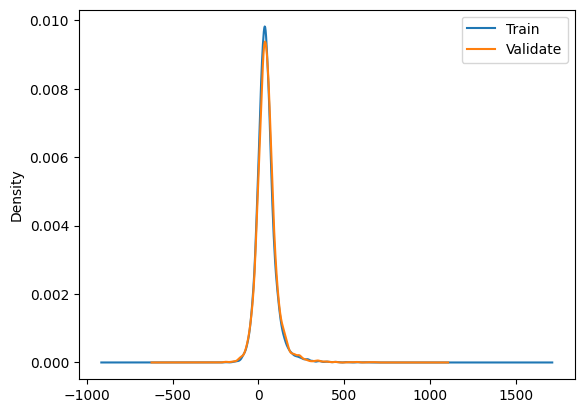

In [146]:
plot_train = stat_sum_train.df.rename(columns={"diff": "Train"})
plot_val = stat_sum_val.df.rename(columns={"diff": "Validate"})

fig, ax = plt.subplots()
plot_train["Train"].plot(kind='density', ax=ax, legend=True)
plot_val["Validate"].plot(kind='density', ax=ax, legend=True)

## Abstract

In [36]:
stat_abs_train = tripStat("abstract", "train")
stat_abs_train.show()


Processing [==================================================] 8379/8379


,paper_id,original,original_len,free_entities,trip_entities,triple_seq,triple_len,diff,diff_percent
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,We study the average CVloo stability of kernel...,93,"{'risk bounds': 'OtherScientificTerm', 'CVloo ...","{'average CVloo stability': 'Metric', 'kernel ...",average CVloo stability FEATURE-OF kernel ridg...,38,55,59.139785
0,SP:b80bc890180934092cde037b49d94d6e4e06fad9,The use of episodic memories in continual lear...,148,{'gradients': 'OtherScientificTerm'},"{'episodic memories': 'OtherScientificTerm', '...",episodic memories USED-FOR catastrophic forget...,118,30,20.270270
0,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,Existing Multi - Task Learning(MTL ) strategie...,293,{'finetuning phase': 'Task'},"{'shared learning': 'Method', 'Multi - Task Le...",shared learning USED-FOR Multi - Task Learning...,345,-52,-17.747440
0,SP:a1e2218e6943bf138aeb359e23628676b396ed66,This paper deals with the fuel optimization pr...,224,"{'hybrid electric vehicle': 'Task', 'uncertain...","{'fuel optimization problem': 'Task', 'hybrid ...",fuel optimization problem USED-FOR hybrid elec...,284,-60,-26.785714
0,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,Our work is concerned with the generation and ...,199,{'generation and targeted design of RNA': 'Tas...,"{'RNA': 'Material', 'genetic macromolecule': '...",RNA HYPONYM-OF genetic macromolecule. graph - ...,150,49,24.623116
...,...,...,...,...,...,...,...,...,...
0,SP:77d59e1e726172184249bdfdd81011617dc9c208,Quantum machine learning methods have the pote...,139,"{'machine learning models': 'Method', 'feature...","{'Quantum machine learning methods': 'Method',...",Quantum machine learning methods USED-FOR lear...,110,29,20.863309
0,SP:e58dc2d21175a62499405b7f4c3a03b135530838,Trained generative models have shown remarkabl...,216,"{'models': 'Generic', 'out - of - distribution...","{'generative models': 'Method', 'priors': 'Gen...",generative models USED-FOR priors. priors USED...,255,-39,-18.055556
0,SP:0d872fb4321f3a4a3fc61cf4d33b0c7e33f2d695,Discovering the underlying mathematical expres...,178,{'mathematical expressions': 'OtherScientificT...,"{'deep learning approaches': 'Method', 'symbol...",deep learning approaches USED-FOR symbolic reg...,115,63,35.393258
0,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,Some conventional transforms such as Discrete ...,198,"{'DNNs': 'Method', 'computation overheads': 'O...",{'Discrete Walsh - Hadamard Transform ( DWHT )...,Discrete Walsh - Hadamard Transform ( DWHT ) C...,226,-28,-14.141414


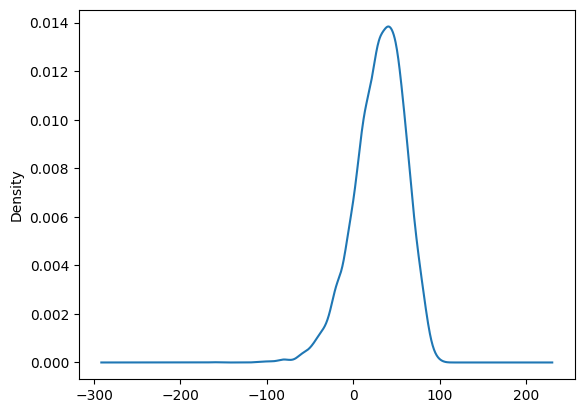

In [37]:
stat_abs_train.showDist()

In [38]:
stat_abs_train.describe()

,original_len,triple_len,diff,diff_percent
max,7819.0,2938.0,4881.000000,100.000000
mean,208.778494,142.484903,66.293591,30.418457
min,14.0,0.0,-231.000000,-161.000000


In [39]:
lowest_sum_trip = stat_abs_train.df[stat_abs_train.df["triple_len"]==0]
lowest_sum_trip

,paper_id,original,original_len,free_entities,trip_entities,triple_seq,triple_len,diff,diff_percent
0,SP:5fefb833a05111c601ed2cad72f356b708c0ec42,"Lukas Schott1 , ‡ , Julius von Kügelgen2 , 3 ,...",74,{},{},,0,74,100.0
0,SP:916cb3c91fce2e7e773ac156a805e2c97a26fa18,We introduce reducible held - out loss selecti...,146,"{'model training': 'Task', 'information - theo...",{},,0,146,100.0
0,SP:968386cd46e1f28b6259b6c26811ed1b8a10ac36,The abstract paragraph should be indented 1/2 ...,420,"{'vertical spacing': 'OtherScientificTerm', 'I...",{},,0,420,100.0
0,SP:0b058184db5e97fce5bed580f3709d6fe67af6a9,We study multi - agent reinforcement learning ...,254,{'multi - agent reinforcement learning ( MARL ...,{},,0,254,100.0
0,SP:e711969866144e09e64210478692e2ee9f331b14,We give a tight characterization of the ( vect...,60,"{'hidden - layer ReLU network': 'Method', 'uni...",{},,0,60,100.0


In [168]:
for idx, row in lowest_sum_trip.iterrows():
    print(row['paper_id'])
    print(row['original'])
    ent_count = {}
    for ent_type in ent_types: ent_count[ent_type]=0
    for k,v in row['free_entities'].items(): ent_count[v] += 1
    print(ent_count)


SP:5fefb833a05111c601ed2cad72f356b708c0ec42
Lukas Schott1 , ‡ , Julius von Kügelgen2 , 3 , 4 , Frederik Träuble2 , 4 , Peter Gehler4 , Chris Russell4 , Matthias Bethge1 , 4 , Bernhard Schölkopf2 , 4 , Francesco Locatello4 , † , Wieland Brendel1 , † 1University of Tübingen , 2Max Planck Institute for Intelligent Systems , Tübingen 3University of Cambridge , 4Amazon Web Services †Joint senior authors , ‡Work done during an internship at Amazon lukas.schott@bethgelab.org
{'Task': 0, 'Method': 0, 'Material': 0, 'Metric': 0, 'OtherScientificTerm': 0, 'Generic': 0}
SP:916cb3c91fce2e7e773ac156a805e2c97a26fa18
We introduce reducible held - out loss selection ( RHOLS ) , a technique for faster model training which selects training points that are “ just right ” . We propose an information - theoretic selection function and a tractable , easy - to - implement approximation — the reducible held - out loss — to efficiently choose training points that maximize information about a holdout set . We s

In [42]:
lowest_sum_trip[lowest_sum_trip["paper_id"]=="SP:916cb3c91fce2e7e773ac156a805e2c97a26fa18"]["free_entities"][0]

{'model training': 'Task',
 'information - theoretic selection function': 'Method',
 'reducible held - out loss': 'OtherScientificTerm',
 'holdout set': 'OtherScientificTerm',
 'optimization literature': 'Material',
 'real - world , noisy datasets': 'Material',
 'curriculum learning': 'Task',
 'RHOLS': 'Method'}

In [50]:
stat_abs_val = tripStat("abstract", "val")
stat_abs_val.show()

Processing [==================================================] 1060/1060


,paper_id,original,original_len,free_entities,trip_entities,triple_seq,triple_len,diff,diff_percent
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,Federated learning ( FL ) is a technique that ...,236,{'sensitive data disclosures': 'OtherScientifi...,"{'Federated learning ( FL )': 'Method', 'machi...",Federated learning ( FL ) USED-FOR machine lea...,215,21,8.898305
0,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,Self - attention networks ( SANs ) have shown ...,155,{'neural networks': 'Method'},{'Self - attention networks ( SANs )': 'Method...,Self - attention networks ( SANs ) USED-FOR na...,144,11,7.096774
0,SP:e3e728837f26acb9da283a42c219b6c3b3e131cb,The field of cybersecurity has mostly been a c...,324,"{'reconnaissance': 'OtherScientificTerm', 'mov...","{'cat - and - mouse game': 'Method', 'cybersec...",cat - and - mouse game USED-FOR cybersecurity....,190,134,41.358025
0,SP:97911e02bf06b34d022e7548beb5169a1d825903,Variational Autoencoder ( VAE ) based framewor...,261,{'model identifiability': 'OtherScientificTerm...,{'unsupervised disentangled representation lea...,unsupervised disentangled representation learn...,123,138,52.873563
0,SP:59f9de3ebe4a04d2fc8778d8e3415bf85efb7822,We present a new zero - shot approach to autom...,191,"{'AutoML systems': 'Method', 'running time': '...","{'zero - shot approach': 'Method', 'automated ...",zero - shot approach USED-FOR automated machin...,155,36,18.848168
...,...,...,...,...,...,...,...,...,...
0,SP:77b8bed08af8be8af0c65a72a6e22cfb02645d02,Statistical inference methods are fundamentall...,155,"{'methods': 'Generic', 'MCMC methods': 'Method...","{'Statistical inference methods': 'Method', 'm...",Statistical inference methods USED-FOR machine...,169,-14,-9.032258
0,SP:64f2744e938bd62cd47c1066dc404a42134953da,"Inferring causal effects of a treatment , inte...",152,"{'covariates': 'OtherScientificTerm', 'real - ...","{'treatment': 'OtherScientificTerm', 'Inferrin...",treatment USED-FOR Inferring causal effects. o...,94,58,38.157895
0,SP:971d0d94adf5113ee1bef8df9ea7dbd508cf4cbc,We present a neural architecture search algori...,204,{'edge - partitionings ( colorings )': 'OtherS...,{'neural architecture search algorithm': 'Meth...,neural architecture search algorithm USED-FOR ...,125,79,38.725490
0,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,We undertake the problem of representation lea...,190,"{'representation': 'Generic', 'invertible maps...","{'time - series': 'Material', 'representation ...",time - series USED-FOR representation learning...,108,82,43.157895


In [51]:
stat_abs_val.describe()

,original_len,triple_len,diff,diff_percent
max,754.0,424.0,413.000000,100.000000
mean,207.666038,141.937736,65.728302,30.358530
min,30.0,0.0,-140.000000,-66.037736


In [52]:
lowest_sum_trip_val = stat_abs_val.df[stat_abs_val.df["triple_len"]==0]
lowest_sum_trip_val

,paper_id,original,original_len,free_entities,trip_entities,triple_seq,triple_len,diff,diff_percent
0,SP:f2c3dd2b485d6307847c759a5609b7ebe24b7058,We present a simple neural model that given a ...,110,"{'neural model': 'Method', 'propositional form...",{},,0,110,100.0
0,SP:f2bee0c4a6c558970538b422e5e36750447cd9bc,We consider two - alternative elections where ...,158,"{'two - alternative elections': 'Task', 'state...",{},,0,158,100.0


In [53]:
for idx, row in lowest_sum_trip_val.iterrows():
    print(row['paper_id'])
    print(row['original'])
    ent_count = {}
    for ent_type in ent_types: ent_count[ent_type]=0
    for k,v in row['free_entities'].items(): ent_count[v] += 1
    print(ent_count)


SP:f2c3dd2b485d6307847c759a5609b7ebe24b7058
We present a simple neural model that given a formula and a property tries to answer the question whether the formula has the given property , for example whether a propositional formula is always true . The structure of the formula is captured by a feedforward neural network recursively built for the given formula in a topdown manner . The results of this network are then processed by two recurrent neural networks . One of the interesting aspects of our model is how propositional atoms are treated . For example , the model is insensitive to their names , it only matters whether they are the same or distinct .
{'Method': 3, 'OtherScientificTerm': 2, 'Task': 0, 'Generic': 2, 'Material': 0, 'Metric': 0}
SP:f2bee0c4a6c558970538b422e5e36750447cd9bc
We consider two - alternative elections where voters ’ preferences depend on a state variable that is not directly observable . Each voter receives a private signal that is correlated to the state vari

In [55]:
lowest_sum_trip_val[lowest_sum_trip_val["paper_id"]=="SP:f2c3dd2b485d6307847c759a5609b7ebe24b7058"]["free_entities"][0]

{'neural model': 'Method',
 'propositional formula': 'OtherScientificTerm',
 'feedforward neural network': 'Method',
 'network': 'Generic',
 'recurrent neural networks': 'Method',
 'model': 'Generic',
 'propositional atoms': 'OtherScientificTerm'}

In [56]:
stat_abs_test = tripStat("abstract", "test")
stat_abs_test.show()

Processing [==================================================] 1052/1052


,paper_id,original,original_len,free_entities,trip_entities,triple_seq,triple_len,diff,diff_percent
0,SP:b19df5243359791fbaad005d6f13d7e9fdb0ff63,Role - based learning holds the promise of ach...,204,"{'joint action spaces': 'OtherScientificTerm',...","{'Role - based learning': 'Method', 'scalable ...",Role - based learning USED-FOR scalable multi ...,123,81,39.705882
0,SP:7deb61890d97422a0fe141ca807f968c70ab239a,This paper studies the behaviour of the stocha...,140,{'convex and strongly - convex objectives': 'O...,{'stochastic subgradient descent ( SSGD ) meth...,stochastic subgradient descent ( SSGD ) method...,119,21,15.000000
0,SP:c7e0b3fedc0d0409d662dd612b529fdacad2b03e,We demonstrate that transformers obtain impres...,78,"{'transformers': 'Method', 'layers': 'OtherSci...",{'non - linear “ reservoir ” layers': 'Method'...,non - linear “ reservoir ” layers CONJUNCTION ...,24,54,69.230769
0,SP:ba9f1d4738ec67a440346f3ac6c4cf35f7232077,Steerable CNN imposes the prior knowledge of t...,173,"{'Steerable CNN': 'Method', 'overfitting': 'Ot...",{'transformation invariance': 'OtherScientific...,transformation invariance CONJUNCTION equivari...,126,47,27.167630
0,SP:c1116fbb4d058eb6be195b5d13d19a55ba86b602,"Multimodal program synthesis , which leverages...",227,{'optimal neural synthesis approach': 'Method'...,"{'Multimodal program synthesis': 'Task', 'prog...",Multimodal program synthesis USED-FOR program....,192,35,15.418502
...,...,...,...,...,...,...,...,...,...
0,SP:0df5ad333eb4ff9cca7f2d117909e2ce533a65d8,Neural conditional text generation systems hav...,163,{'Neural conditional text generation systems':...,"{'them': 'Generic', 'real world systems': 'Tas...",them USED-FOR real world systems. controllabil...,166,-3,-1.840491
0,SP:03307deac29173b2968fbd08f95fc77eb1f82410,Magnitude - based pruning is one of the simple...,118,"{'neural networks': 'Method', 'high - sparsity...","{'Magnitude - based pruning': 'Method', 'pruni...",Magnitude - based pruning USED-FOR pruning neu...,125,-7,-5.932203
0,SP:dc80fdc75bc14ae19fe4ba9b85c35ce00b12856f,Decentralized stochastic gradient descent ( SG...,171,{'Decentralized stochastic gradient descent ( ...,"{'parallel workers': 'OtherScientificTerm', 'g...",parallel workers PART-OF graph. technique USED...,100,71,41.520468
0,SP:86c61a658d07ab86e2d84cef7e480bf7a06e4ddb,"In reinforcement learning , we can learn a mod...",135,"{'reinforcement learning': 'Method', 'it': 'Ge...",{},,0,135,100.000000


In [57]:
lowest_trip_abs_test = stat_abs_test.df[stat_abs_test.df["triple_len"]==0]
lowest_trip_abs_test

,paper_id,original,original_len,free_entities,trip_entities,triple_seq,triple_len,diff,diff_percent
0,SP:3ac5f437fc349a33810d0645664d1c448528af74,ING INFLUENCE PATHS FOR EXPLAINING ( CONTEXTUA...,19,{},{},,0,19,100.0
0,SP:86c61a658d07ab86e2d84cef7e480bf7a06e4ddb,"In reinforcement learning , we can learn a mod...",135,"{'reinforcement learning': 'Method', 'it': 'Ge...",{},,0,135,100.0


In [58]:
for idx, row in lowest_trip_abs_test.iterrows():
    print(row['paper_id'])
    print(row['original'])
    ent_count = {}
    for ent_type in ent_types: ent_count[ent_type]=0
    for k,v in row['free_entities'].items(): ent_count[v] += 1
    print(ent_count)

SP:3ac5f437fc349a33810d0645664d1c448528af74
ING INFLUENCE PATHS FOR EXPLAINING ( CONTEXTUALIZATION OF ) BERT MODELS Anonymous authors Paper under double - blind review
{'Method': 0, 'OtherScientificTerm': 0, 'Task': 0, 'Generic': 0, 'Material': 0, 'Metric': 0}
SP:86c61a658d07ab86e2d84cef7e480bf7a06e4ddb
In reinforcement learning , we can learn a model of future observations and rewards , and use it to plan the agent ’s next actions . However , jointly modeling future observations can be computationally expensive or even intractable if the observations are high - dimensional ( e.g. images ) . For this reason , previous works have considered partial models , which model only part of the observation . In this paper , we show that partial models can be causally incorrect : they are confounded by the observations they do n’t model , and can therefore lead to incorrect planning . To address this , we introduce a general family of partial models that are provably causally correct , yet remain

In [60]:
lowest_trip_abs_test[lowest_trip_abs_test["paper_id"]=="SP:86c61a658d07ab86e2d84cef7e480bf7a06e4ddb"]["free_entities"][0]

{'reinforcement learning': 'Method',
 'it': 'Generic',
 'jointly modeling future observations': 'Task',
 'images': 'Material',
 'partial models': 'Method',
 'they': 'Generic'}

## First section

In [ ]:
filepath = getPath("section_1", "val")
print(filepath)
with open(filepath, 'r') as json_file:
    json_list = list(json_file)
dataset_sec1 = [json.loads(json_str) for json_str in json_list]

_scire_models/section_1/val_re.json


In [ ]:
dataset_sec1

[]

In [ ]:
len_sum_df = getProcessedLen(dataset_sum)

Processing [==================================================] 18934/18934


In [ ]:
len_sum_df = len_sum_df.convert_dtypes()
len_sum_df["diff_percent"] = len_sum_df.apply(lambda row: calPercDiff(row), axis=1)
len_sum_df.describe().loc[["max", "mean", "min"]]

,original_len,triple_len,diff,diff_percent
max,1210.000000,842.000000,1056.000000,100.000000
mean,118.182001,72.080754,46.101246,35.738162
min,24.000000,0.000000,-258.000000,-151.515152


## Summary

In [ ]:
filepath = getPath("summary", "train")
with open(filepath, 'r') as json_file:
    json_list = list(json_file)
dataset_sum = [json.loads(json_str) for json_str in json_list]

In [ ]:
len_sum_df = getProcessedLen(dataset_sum)

Processing [==================================================] 18934/18934


In [ ]:
len_sum_df = len_sum_df.convert_dtypes()
len_sum_df["diff_percent"] = len_sum_df.apply(lambda row: calPercDiff(row), axis=1)
len_sum_df.describe().loc[["max", "mean", "min"]]

,original_len,triple_len,diff,diff_percent
max,1210.000000,842.000000,1056.000000,100.000000
mean,118.182001,72.080754,46.101246,35.738162
min,24.000000,0.000000,-258.000000,-151.515152


# Visuallize KG recheck

## Load generated summary KG

In [32]:
from pathlib import Path
import json
import pandas as pd

main_path = str((Path().absolute()))
models = [
    'bart-large', 
    'bart-large-cnn'
]
experiments = [
    ['abstract-kg', 'abstract-kg'],
    ['summary-kg', 'abstract-kg'],
    ['summary-kg', 'summary-kg'],
]
best_score = ['output_bestRouge1', 'output_bestRougeAvg']
exclude = [
    'bart-large-cnn_abstract-kg_abstract-kg',
    'bart-large-cnn_summary-kg_summary-kg',
]
def load_re(filename):
    filepath = f"_scire_models/csv/{filename}_re.json"
    with open(filepath, 'r') as json_file:
        json_list = list(json_file)
    return [json.loads(json_str) for json_str in json_list]

def load_pre(filename):
    filepath = f"_prepared_data/csv/{filename}.jsonl"
    with open(filepath, 'r') as json_file:
        json_list = list(json_file)
    return [json.loads(json_str) for json_str in json_list]


In [43]:
for model in models:
    for exp in experiments:
        for best in best_score:
            if f"{model}_{exp[0]}_{exp[1]}" in exclude: 
                filename=f"[{model}]_[{exp[0]}]_[{exp[1]}]"
            else:
                filename=f"[{model}]_[{exp[0]}]_[{exp[1]}]_{best[11:]}"
                
            try:
                result_list = load_re(filename)
                print(filename, len(result_list))
                ner = re = 0
                for result in result_list:
                    if len(result['predicted_ner'])==0: ner+=1
                    if len(result['predicted_re'])==0: re+=1
                print(f"\tBlank NER {ner}/{len(result_list)}")
                print(f"\tBlank RE {re}/{len(result_list)}")
            except:
                print(filename, "CANNOT IMPORT")
    #         break
    #     break
    # break
            

[bart-large]_[abstract-kg]_[abstract-kg]_Rouge1 1060
	Blank NER 0/1060
	Blank RE 0/1060
[bart-large]_[abstract-kg]_[abstract-kg]_RougeAvg 1060
	Blank NER 0/1060
	Blank RE 0/1060
[bart-large]_[summary-kg]_[abstract-kg]_Rouge1 1060
	Blank NER 0/1060
	Blank RE 0/1060
[bart-large]_[summary-kg]_[abstract-kg]_RougeAvg 1060
	Blank NER 0/1060
	Blank RE 0/1060
[bart-large]_[summary-kg]_[summary-kg]_Rouge1 3604
	Blank NER 0/3604
	Blank RE 3599/3604
[bart-large]_[summary-kg]_[summary-kg]_RougeAvg 3604
	Blank NER 0/3604
	Blank RE 3600/3604
[bart-large-cnn]_[abstract-kg]_[abstract-kg] 1060
	Blank NER 0/1060
	Blank RE 0/1060
[bart-large-cnn]_[abstract-kg]_[abstract-kg] 1060
	Blank NER 0/1060
	Blank RE 0/1060
[bart-large-cnn]_[summary-kg]_[abstract-kg]_Rouge1 1060
	Blank NER 0/1060
	Blank RE 1057/1060
[bart-large-cnn]_[summary-kg]_[abstract-kg]_RougeAvg 1060
	Blank NER 0/1060
	Blank RE 1057/1060
[bart-large-cnn]_[summary-kg]_[summary-kg] 3604
	Blank NER 0/3604
	Blank RE 3600/3604
[bart-large-cnn]_[su

In [45]:
[" ".join(sent) for sent in result_list[0]['sentences']]

['This paper studies the problem of local differential privacy constraints in FL .',
 'The authors propose a gradient subsampling strategy to reduce the communication costs and improve privacy - preserving FL algorithms .',
 'The main contribution of the paper is to propose a new gradient - based learning algorithm sqSGD .',
 'The key idea is to apply randomized rotation to the quantization error of the base algorithm to improve the communication efficiency and highdimensional compatibility .']

In [46]:
result_list[0]['predicted_ner']

[[[6, 9, 'Task'], [11, 11, 'Task']],
 [[17, 19, 'Method'], [23, 24, 'Metric'], [27, 31, 'Method']],
 [[44, 49, 'Method']],
 [[57, 58, 'OtherScientificTerm'],
  [61, 62, 'OtherScientificTerm'],
  [65, 66, 'Generic'],
  [70, 71, 'Metric'],
  [73, 74, 'Metric']]]

In [47]:
result_list[0].keys()

dict_keys(['doc_key', 'sentences', 'ner', 'relations', 'predicted_ner', 'predicted_re'])

## Load reference summary KG

In [48]:
def load_refKG():
    filepath = "_scire_models/MuP/summary/val_re.json"
    with open(filepath, 'r') as json_file:
        json_list = list(json_file)
    return [json.loads(json_str) for json_str in json_list]

def evaluate(gen):
    drop_col = ["sentences", "ner", "relations", "predicted_re"]
    ref = pd.DataFrame(load_refKG()).drop(drop_col, axis=1).rename(columns={"predicted_ner": "ref_ner"})
    gen = gen.drop(drop_col, axis=1).rename(columns={"predicted_ner": "gen_ner"})
    return pd.merge(gen, ref, on='doc_key', how='outer')

In [49]:
evaluate(pd.DataFrame(result_list))

,doc_key,gen_ner,ref_ner
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,"[[[6, 9, Task], [11, 11, Task]], [[17, 19, Met...","[[[3, 3, Task], [5, 8, OtherScientificTerm]], ..."
1,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,"[[[6, 9, Task], [11, 11, Task]], [[17, 19, Met...","[[[4, 6, Method], [8, 10, Task], [13, 15, Mate..."
2,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,"[[[6, 9, Task], [11, 11, Task]], [[17, 19, Met...","[[[4, 7, Method], [9, 10, Method]], [[17, 18, ..."
3,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,"[[[4, 6, Method], [8, 10, Task], [13, 15, Task...","[[[3, 3, Task], [5, 8, OtherScientificTerm]], ..."
4,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,"[[[4, 6, Method], [8, 10, Task], [13, 15, Task...","[[[4, 6, Method], [8, 10, Task], [13, 15, Mate..."
...,...,...,...
13099,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,"[[], [], [], [], []]","[[[4, 7, OtherScientificTerm], [9, 9, Method]]..."
13100,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,"[[], [], [], [], []]","[[[7, 8, Task], [10, 13, OtherScientificTerm]]..."
13101,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,"[[], [], []]","[[[5, 10, Method], [13, 18, Method], [21, 25, ..."
13102,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,"[[], [], []]","[[[4, 7, OtherScientificTerm], [9, 9, Method]]..."


In [52]:
df = pd.DataFrame(result_list)
print(df['sentences'][4])

[['This', 'paper', 'proposes', 'a', 'new', 'method', 'to', 'incorporate', 'prior', 'knowledge', 'into', 'Transformer', '-', 'based', 'sentence', 'encoders', 'for', 'neural', 'machine', 'translation', '(', 'NMT', ')', '.'], ['The', 'prior', 'knowledge', 'matrix', 'is', 'constructed', 'from', 'the', 'query', 'matrix', 'of', 'the', 'NMT', 'component', ',', 'and', 'this', 'matrix', 'is', 'used', 'to', 'encode', 'the', 'prior', 'knowledge', 'of', 'the', 'Transformer', 'encoder', '.'], ['A', 'gating', 'mechanism', 'is', 'also', 'introduced', 'to', 'control', 'the', 'quality', 'of', 'Transformer', 'decoder', 'output', '.'], ['Experiments', 'show', 'that', 'the', 'proposed', 'procedure', 'is', 'able', 'to', 'learn', 'a', 'prior', 'knowledge', 'representation', 'matrix', 'that', 'can', 'be', 'used', 'to', 'improve', 'the', 'performance', 'of', 'a', 'Transformer', 'self', '-', 'attention', 'mechanism', '.']]


In [34]:
ref = pd.DataFrame(load_refKG()).drop(drop_col, axis=1).rename(columns={"predicted_ner": "ref_ner"})
ref

,doc_key,sentences,ner,relations,predicted_ner,predicted_re
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,"[[This, paper, studies, FL, under, local, diff...","[[], [], [], []]","[[], [], [], []]","[[[3, 3, Task], [5, 8, OtherScientificTerm]], ...","[[0, [[[5, 8], [3, 3], 'FEATURE-OF']]], [1, [[..."
1,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,"[[This, paper, studies, a, low, communication,...","[[], [], [], [], []]","[[], [], [], [], []]","[[[4, 6, Method], [8, 10, Task], [13, 15, Mate...","[[0, [[[4, 6], [8, 10], 'USED-FOR'], [[13, 15]..."
2,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,"[[The, paper, proposed, a, differentially, pri...","[[], [], [], [], []]","[[], [], [], [], []]","[[[4, 7, Method], [9, 10, Method]], [[17, 18, ...","[[0, [[[4, 7], [9, 10], 'USED-FOR']]], [1, []]..."
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,"[[This, submission, works, on, the, neural, ma...","[[], [], [], [], []]","[[], [], [], [], []]","[[[5, 8, Task]], [[18, 19, OtherScientificTerm...","[[0, []], [1, [[[18, 19], [21, 22], 'CONJUNCTI..."
4,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,"[[This, paper, proposes, a, method, to, introd...","[[], [], [], []]","[[], [], [], []]","[[[4, 4, Generic], [9, 10, OtherScientificTerm...","[[0, [[[14, 18], [25, 30], 'USED-FOR'], [[4, 4..."
...,...,...,...,...,...,...
3599,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,"[[This, paper, defines, a, set, of, learnable,...","[[], [], []]","[[], [], []]","[[[11, 13, Method], [16, 16, Generic]], [[26, ...","[[0, [[[11, 13], [16, 16], 'USED-FOR']]], [1, ..."
3600,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,"[[A, typical, Wavelet, Transform, is, built, t...","[[], [], []]","[[], [], []]","[[[2, 3, Method], [8, 14, OtherScientificTerm]...","[[0, [[[22, 23], [26, 27], 'FEATURE-OF'], [[8,..."
3601,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,"[[This, paper, builds, a, new, graph, convolut...","[[], [], [], [], []]","[[], [], [], [], []]","[[[5, 10, Method], [13, 18, Method], [21, 25, ...","[[0, [[[13, 18], [5, 10], 'USED-FOR']]], [1, [..."
3602,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,"[[The, authors, propose, using, non, -, Euclid...","[[], [], [], [], []]","[[], [], [], [], []]","[[[4, 7, OtherScientificTerm], [9, 9, Method]]...","[[0, [[[4, 7], [9, 9], 'USED-FOR']]], [2, [[[3..."
